In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import random
import cv2

In [2]:
import json
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 12345

In [3]:
from zipfile import ZipFile
parkinson_data = 'ParkinsonImageData.zip'
with ZipFile(parkinson_data, 'r') as zip1:
    zip1.extractall()
    print('Done')

Done


In [4]:
DIRECTORY = 'ParkinsonImageData/training'
CATEGORIES = ["parkinson","healthy"]

data = []
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        label = CATEGORIES.index(category)
        arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        new_arr = cv2.resize(arr, (4, 4))
        data.append([new_arr, label])
        
random.shuffle(data)

In [5]:
X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)
    
X = np.array(X)
y = np.array(y)

X=X/225
X=X.reshape(X.shape[0], -1)

In [8]:
X

array([[1.07555556, 1.05777778, 1.02222222, ..., 1.03555556, 1.03555556,
        1.04888889],
       [1.05333333, 1.05777778, 1.03555556, ..., 1.08      , 1.07555556,
        1.06666667],
       [1.06222222, 1.00888889, 1.05333333, ..., 1.03555556, 0.57777778,
        1.07111111],
       ...,
       [1.08444444, 1.04444444, 0.98666667, ..., 1.02666667, 1.04      ,
        1.00888889],
       [1.05333333, 1.05777778, 0.99111111, ..., 1.04      , 1.01333333,
        1.04      ],
       [1.03555556, 1.08      , 1.02666667, ..., 1.05333333, 1.04888889,
        1.04444444]])

In [9]:
y

array([0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1])

# Convolution Circuit and Convolution Layer

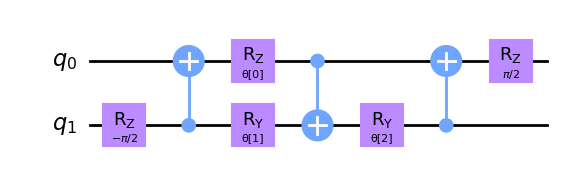

In [10]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

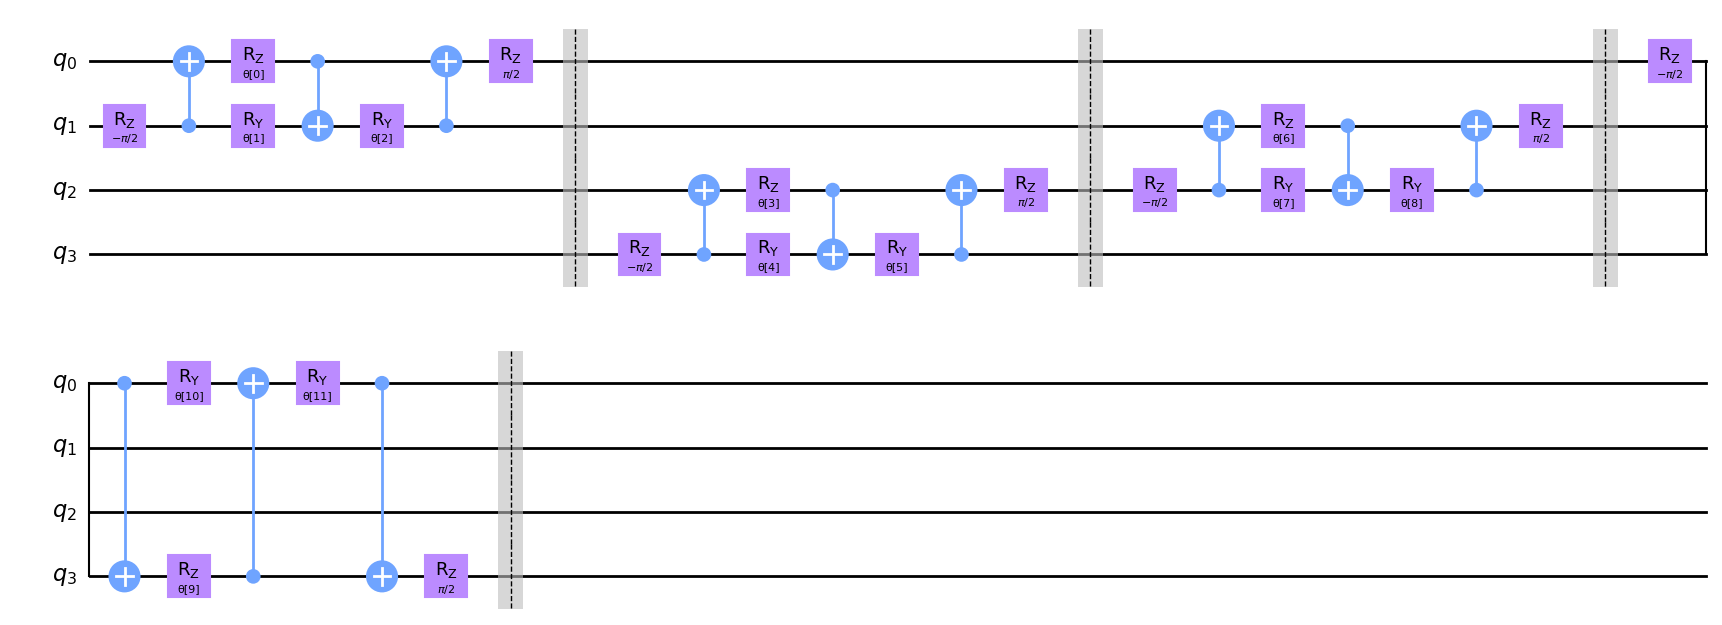

In [11]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")


# Pooling Circuitand Pooling Layer

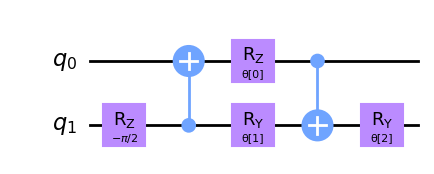

In [12]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

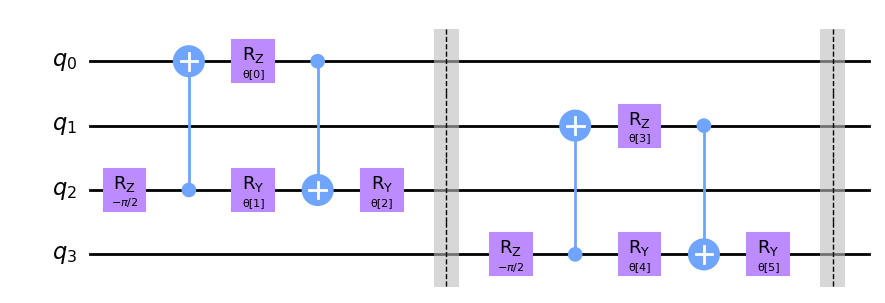

In [13]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

# ZFeatureMap

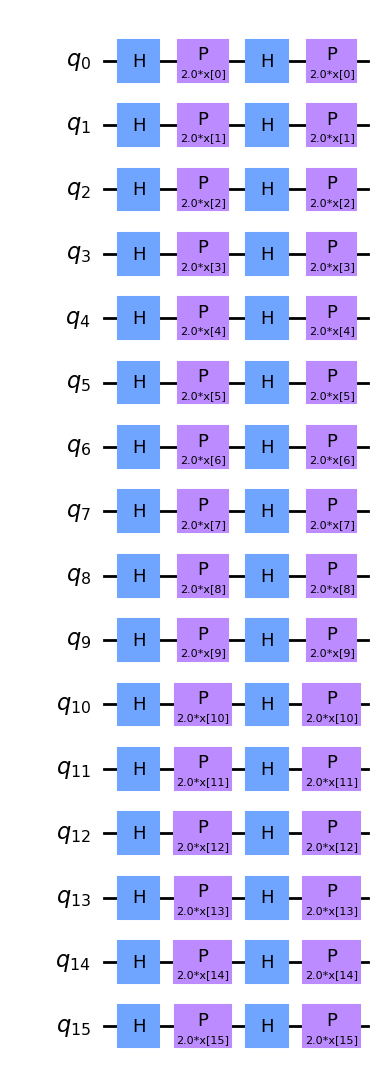

In [14]:
feature_map = ZFeatureMap(16)
feature_map.decompose().draw("mpl")

# QCNN

In [15]:
feature_map = ZFeatureMap(16)

ansatz = QuantumCircuit(16, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(16, "с1"), list(range(16)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10 ,11, 12, 13, 14, 15], "p1"), list(range(16)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(8, "с2"), list(range(8,16)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p2"), list(range(8,16)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(4, "c3"), list(range(12, 16)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p3"), list(range(12, 16)), inplace=True)

# Fourth Convolutional Layer
ansatz.compose(conv_layer(2, "c4"), list(range(14, 16)), inplace=True)

# Fourth Pooling Layer
ansatz.compose(pool_layer([0], [1], "p4"), list(range(14, 16)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(16)
circuit.compose(feature_map, range(16), inplace=True)
circuit.compose(ansatz, range(16), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 15, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)
# circuit.draw("mpl")

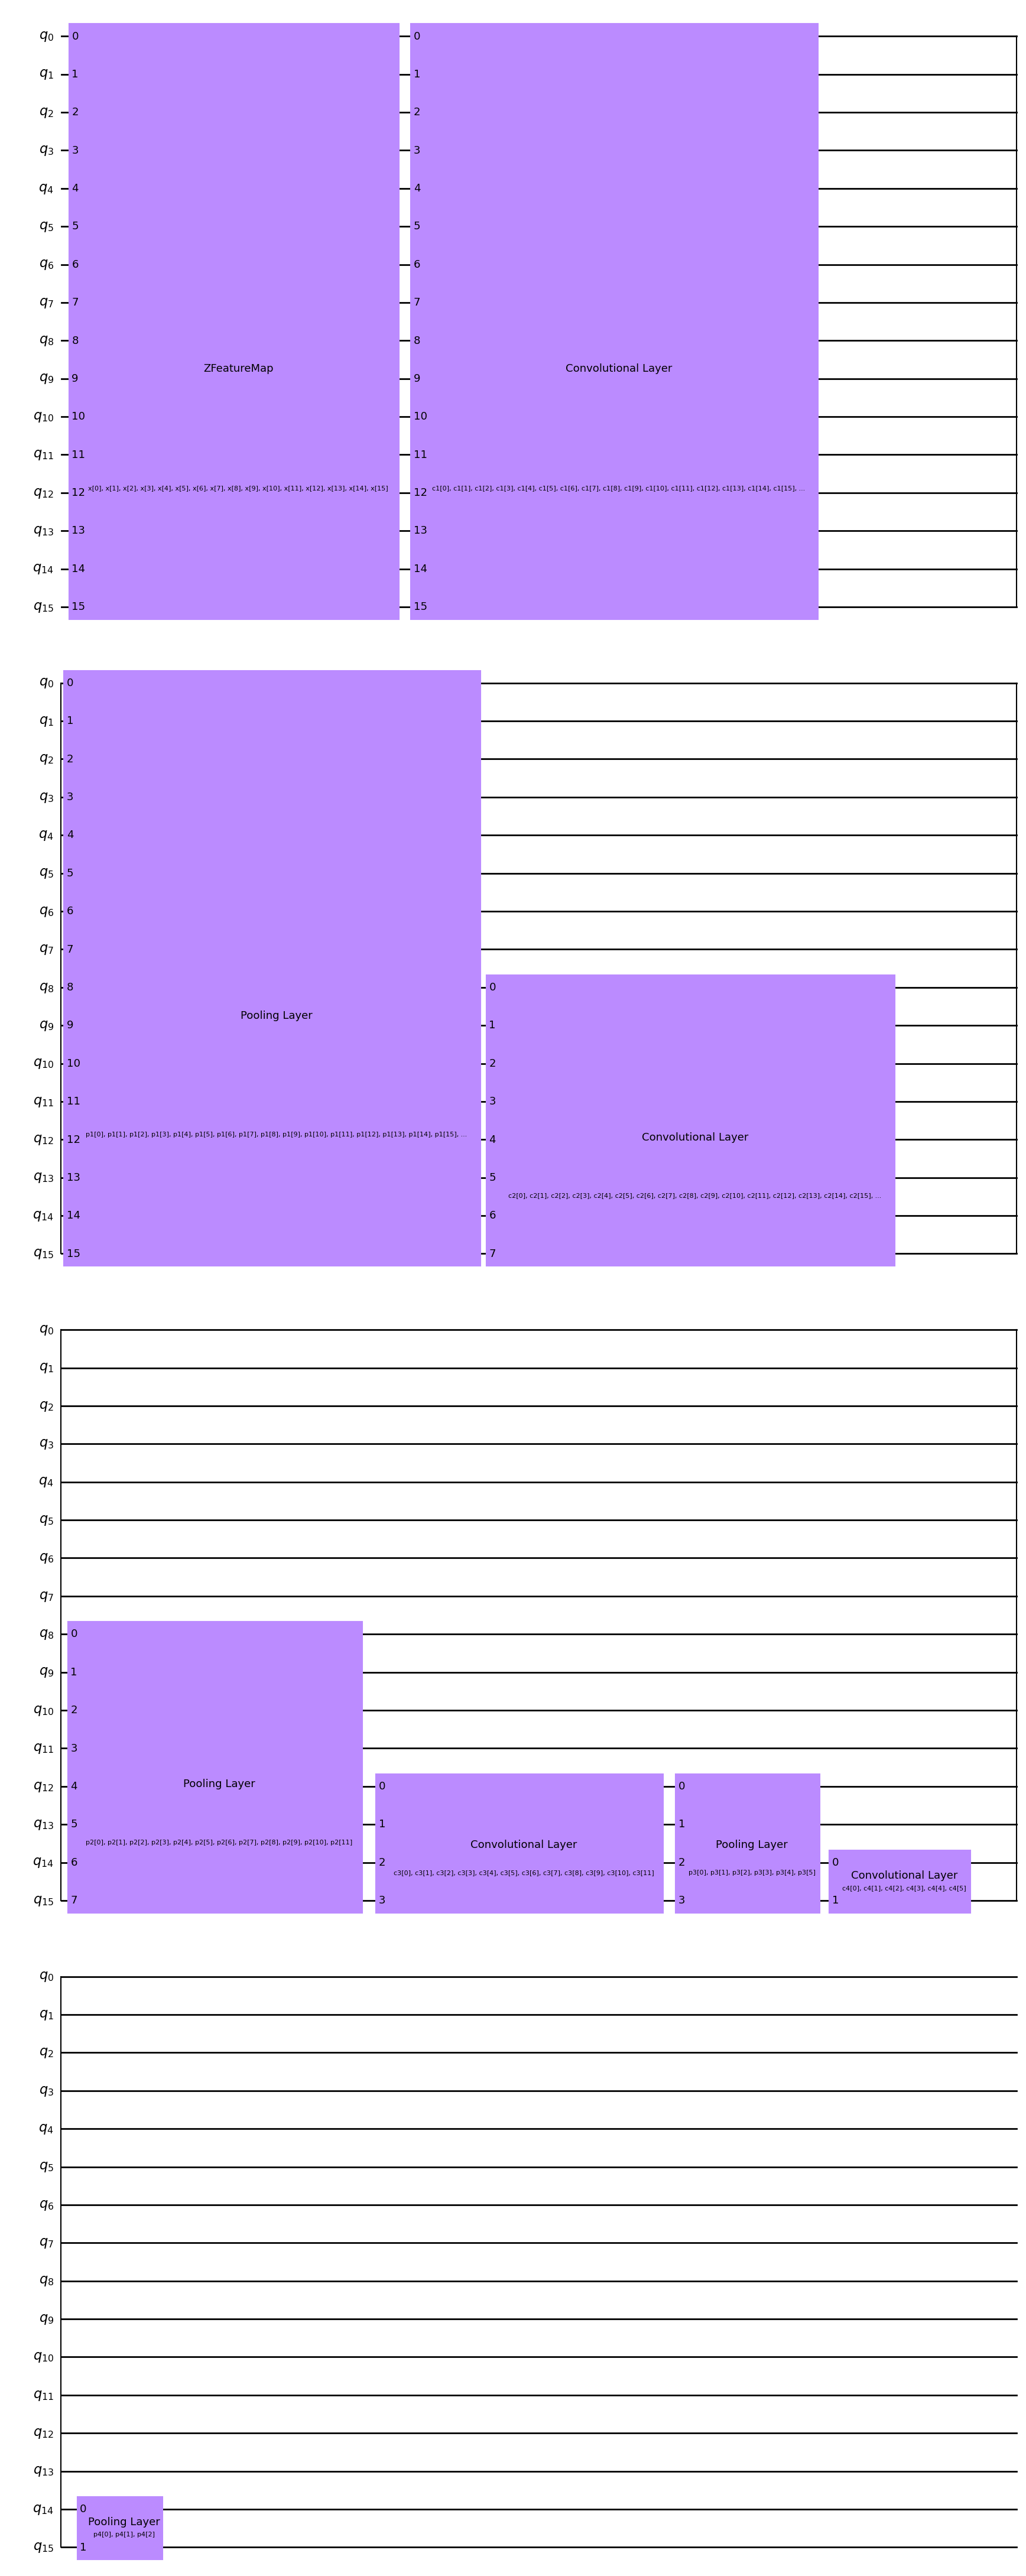

In [16]:
circuit.draw("mpl")

In [17]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [18]:
# with open("11_qcnn_initial_point.json", "r") as f:
#     initial_point = json.load(f)

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=10),  # Set max iterations here
    callback=callback_graph,
#     initial_point=X,
)

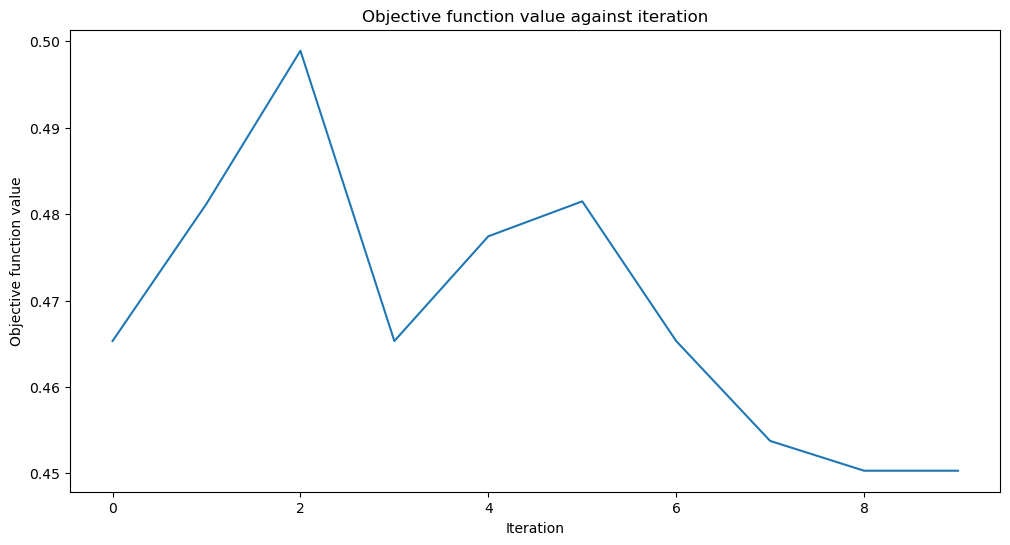

Accuracy from the train data : 50.0%


In [19]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(X, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(X, y), 2)}%")

In [29]:
DIRECTORY = 'ParkinsonImageData/testing'
CATEGORIES = ["parkinson","healthy"]

data = []
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        label = CATEGORIES.index(category)
        arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        new_arr = cv2.resize(arr, (4, 4))
        data.append([new_arr, label])
        
random.shuffle(data)

In [30]:
X_test = []
y_test = []

for features, label in data:
    X_test.append(features)
    y_test.append(label)
    
X_test = np.array(X_test)
y_test = np.array(y_test)

X_test=X_test/225
X_test=X_test.reshape(X_test.shape[0], -1)

In [31]:
y_predict = classifier.predict(X_test)

print(f"Accuracy from the test data : {np.round(100 * classifier.score(X_test, y_test), 2)}%")


Accuracy from the test data : 50.0%


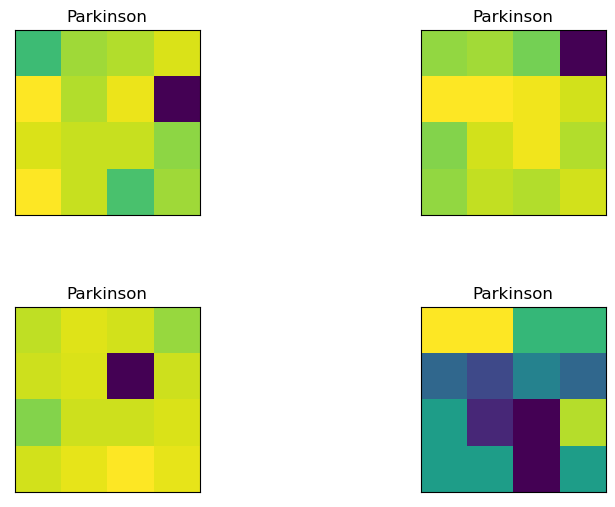

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(X_test[i].reshape(4, 4), aspect="equal")
    if y_predict[i] == 1:
        ax[i // 2, i % 2].set_title("Parkinson")
    if y_predict[i] == 0:
        ax[i // 2, i % 2].set_title("Healthy")
plt.subplots_adjust(wspace=0.1, hspace=0.5)